In [1]:
import numpy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#this is just a placeholder, eventually I will convert proprocess_output to a .py and load it as a module
#And then this code will be relevant:
#data = preprocess_output.get_data()
%run preprocess_output.ipynb

In [3]:
#dropping one-hot encodings now
data = data.drop(columns=['cloud_BK', 'cloud_CL', 'cloud_FW', 'cloud_OV', 'cloud_SC', 'lightning_prob_H', 'lightning_prob_L', 'lightning_prob_M', 'lightning_prob_N', 'precip_False', 'precip_True', 'Airport_KMEM', 'Season_autumn', 'Season_spring', 'Season_summer', 'Season_winter'])

In [4]:
scaler = MinMaxScaler()

train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=False)

#This is super ugly b/c a lot of it was retroactively modified for part 3 
normalized_data = scaler.fit_transform(train_data.iloc[:,:-1])
normalized_val_data = scaler.fit_transform(val_data.iloc[:,:-1])
normalized_test_data = scaler.fit_transform(test_data.iloc[:,:-1])
truth = scaler.fit_transform(train_data.iloc[:,-1].to_numpy().reshape(-1,1))
val_truth = scaler.fit_transform(val_data.iloc[:,-1].to_numpy().reshape(-1,1))
test_truth = scaler.fit_transform(test_data.iloc[:,-1].to_numpy().reshape(-1,1))

print(truth)

[[0.0212766 ]
 [0.04787234]
 [0.07446809]
 ...
 [0.01595745]
 [0.05851064]
 [0.03723404]]


In [11]:
input_size = len(data.columns)-1
hidden_size = 256 # Arbitrarily chosen, hyperparameter optimization should be done
output_size = 1  # Future #arrivals
num_layers = 1 # Layers in LTSM
seqsize = 32 # Sliding window of how far back to look
# I added batch size to make it work better but it works best on 1, pain
batch_size = 1

class CustomDataset(Dataset):
    def __init__(self, training, truth, window_size=seqsize):
        self.data = training
        self.targets = truth
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        sample = self.data[idx:idx+self.window_size]
        target = self.targets[idx+self.window_size-1]
        
        sample = torch.tensor(sample, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        
        return sample, target

trainingset = CustomDataset(training=normalized_data, truth=truth)
valset = CustomDataset(training=normalized_val_data, truth=val_truth)
testset = CustomDataset(training=normalized_test_data, truth=test_truth)

train_loader = torch.utils.data.DataLoader(dataset=trainingset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seqsize = seqsize # Sequence size for sliding window
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, output_size) # this is for 1 layer networks
        self.fc = nn.Linear(hidden_size, 64) # 1st full layer
        self.fc2 = nn.Linear(64, output_size) # 2nd full layer
        self.leakyrelu = nn.LeakyReLU() 
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden and cell states for all layers
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate through the LSTM layers
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Use only the final time step output for prediction
        out = out[:, -1, :]  # Shape: [batch_size, hidden_size]
        
        # Pass through fully connected layers
        out = self.leakyrelu(self.fc(out))
        out = self.dropout(out)
        out = self.fc2(out)  # Final output with shape [batch_size, output_size]
        return out

model = RNN(input_size, hidden_size, output_size, num_layers)

In [12]:
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=.001)
best = float('inf')
patience = 50
counter = 0
model = model.to(device)
start=time.perf_counter()

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mse(outputs.squeeze(), targets.squeeze())
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            val_outputs = model(inputs)
            val_loss += mse(val_outputs.squeeze(), targets).item()
        val_loss /= len(val_loader)
    
    if epoch % 5 == 0:
        end = time.perf_counter()
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {loss}, Val Loss: {val_loss}, Time: {end-start}' )
        start=time.perf_counter()
    if val_loss < best:
        best = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Validation loss did not improve for {} epochs. Early stopping.".format(patience))
            break
torch.save(model.state_dict(), 'RNN_FORECAST.pth')

Epoch [0/100], Train Loss: 0.0042862482368946075, Val Loss: 0.03197866041488452, Time: 71.70809110699338


/scratch/294767.1.ood/ipykernel_321082/1752307165.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('RNN_FORECAST.pth'))
/scratch/294767.1

Test Loss: 0.013622315600514412


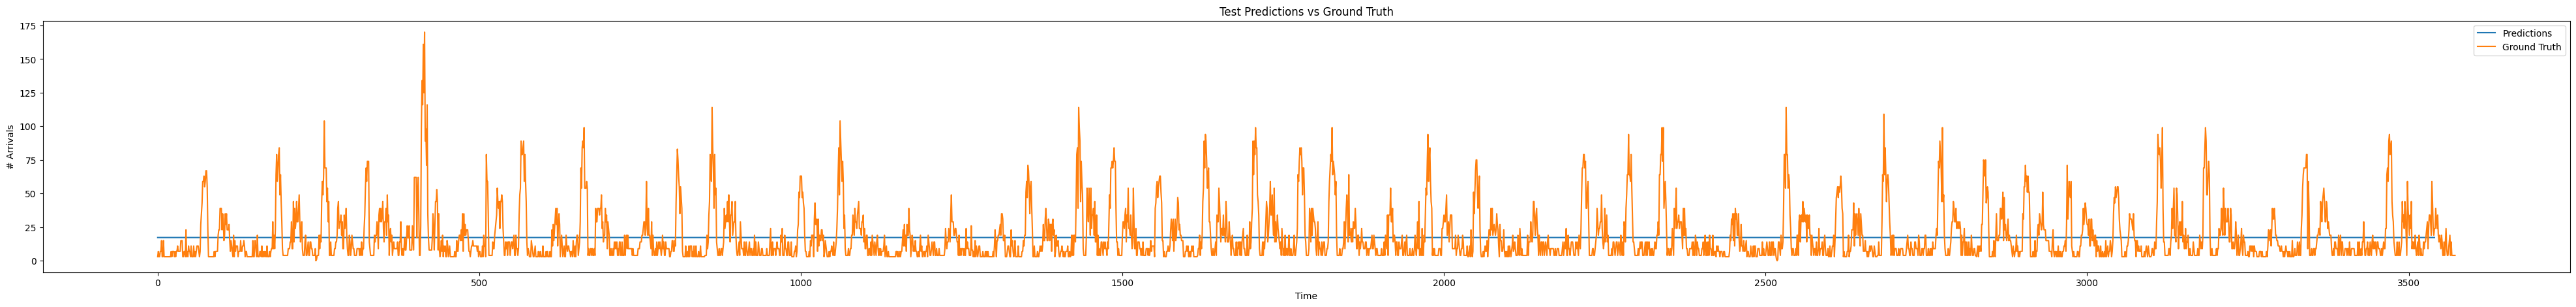

In [7]:
# Load the model and set it to evaluation mode
model.load_state_dict(torch.load('RNN_FORECAST.pth'))
model.eval()
model = model.to(device)

# Reshape X_test to fit the model’s expected input dimensions
# Assuming that the shape of normalized_test_data is (total_samples, input_features)
num_samples = len(normalized_test_data) - seqsize  # Adjust for sliding window
input_size = len(normalized_test_data[0])  # Number of features in the data

# Convert the test data into the shape (num_samples, seqsize, input_size)
X_test = []
for i in range(num_samples):
    X_test.append(normalized_test_data[i:i+seqsize])

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Run the model on test data
with torch.no_grad():
    test_outputs = model(X_test)

# Squeeze and detach output for plotting
test_outputs = test_outputs.squeeze(dim=2).cpu().numpy() if len(test_outputs.shape) != 2 else test_outputs.detach().cpu().numpy()

# Inverse transform predictions and ground truth
test_predictions = scaler.inverse_transform(test_outputs)
test_truth_unnormal = scaler.inverse_transform(test_truth)

# Calculate the test loss
mse2 = nn.MSELoss()
test_loss = mse2(
    torch.tensor(test_outputs.squeeze(), dtype=torch.float32),
    torch.tensor(test_truth, dtype=torch.float32)
)

print(f"Test Loss: {test_loss}")

# Plot the results
plt.figure(figsize=(50, 5))
plt.plot(test_predictions, label='Predictions')
plt.plot(test_truth_unnormal, label='Ground Truth')
plt.xlabel('Time')
plt.ylabel('# Arrivals')
plt.title('Test Predictions vs Ground Truth')
plt.legend()
plt.show()